<a href="https://colab.research.google.com/github/Dedalus1982/MIPHI_Kurs_Classik_ML/blob/main/Kurs_classic_DAF_SI8_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка и подготовка данных:

In [ ]:
!pip install catboost -q
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 5.2 MB/s eta 0:00:00


In [ ]:
# Подключение к Google Drive и работа с файлами
from google.colab import drive
drive.mount('/content/drive')

# Библиотеки для работы с данными
import pandas as pd
import numpy as np

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_contour

# Статистические методы
from scipy.stats import mannwhitneyu

# Машинное обучение
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Регрессоры
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                             GradientBoostingClassifier, HistGradientBoostingClassifier)
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Метрики
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            classification_report)

import joblib
from pickle import TRUE
import os
import optuna

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/'
handmade = pd.read_csv(os.path.join(data_dir,'df_handmade.csv')).drop(columns=['CC50', 'IC50'])
pca = pd.read_csv(os.path.join(data_dir,'pca_cleaned_SI.csv'))
tsne = pd.read_csv(os.path.join(data_dir,'tsne_cleaned_SI.csv'))
umap = pd.read_csv(os.path.join(data_dir,'umap_cleaned_SI.csv'))

In [ ]:
# @title Подготовка данных для моделирования
analyse_name = 'class8'
base_parameter = 'SI'

# подготовка данных для handmade
metod_name_1 = 'handmade'

handmade['target'] = (handmade[base_parameter] > 8).astype(int)
X1 = handmade.drop(columns=[base_parameter, 'target'])
y1 = handmade['target']

base_name1 = f"{base_parameter}_{analyse_name}_{metod_name_1}"
table_1 = f"table_{base_name1}.csv"
final_1 = f"{base_name1}_"

# подготовка данных для pca
metod_name_2 = 'pca'

pca['target'] = (pca[base_parameter] > 8).astype(int)
X2 = pca.drop(columns=[base_parameter, 'target'])
y2 = pca['target']

base_name2 = f"{base_parameter}_{analyse_name}_{metod_name_2}"
table_2 = f"table_{base_name2}.csv"
final_2 = f"{base_name2}_"

# подготовка данных для tsne
metod_name_3 = 'tsne'

tsne['target'] = (tsne[base_parameter] > 8).astype(int)
X3 = tsne.drop(columns=[base_parameter, 'target'])
y3 = tsne['target']

base_name3 = f"{base_parameter}_{analyse_name}_{metod_name_3}"
table_3 = f"table_{base_name3}.csv"
final_3 = f"{base_name3}_"

# подготовка данных для umap
metod_name_4 = 'umap'

umap['target'] = (umap[base_parameter] > 8).astype(int)
X4 = umap.drop(columns=[base_parameter, 'target'])
y4 = umap['target']

base_name4 = f"{base_parameter}_{analyse_name}_{metod_name_4}"
table_4 = f"table_{base_name4}.csv"
final_4 = f"{base_name4}_"

# название файла с хранением всех результатов
csv_file_final = f"{analyse_name}_{base_parameter}.csv"

# МОДЕЛИРОВАНИЕ

In [ ]:
# @title класс ClassificationModelEvaluator для анализа моделей
class ClassificationModelEvaluator:
    def __init__(self, X, y, test_size=0.2, random_state=42,
                 models_config=None, metod_name="", data_dir=None):
        self.X = X.copy()
        self.y = y.copy()
        self.test_size = test_size
        self.random_state = random_state
        self.models = {}
        self.results = None
        self.best_model = None
        self.metod_name = metod_name
        self.grid_search_results = {}  # Для хранения GridSearchCV объектов
        self.data_dir = data_dir or '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/'

        # Разделение данных
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y,
            test_size=test_size,
            random_state=random_state,
            stratify=self.y
        )

        # Инициализация моделей
        if models_config is None:
            self.models = self.create_models_config()
        else:
            self.models = models_config

    def create_models_config(self):
        models_config = {
            'LogisticRegression': {
                'model': make_pipeline(
                    StandardScaler(),
                    LogisticRegression(max_iter=2000)
                ),
                'params': {
                    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
                    'logisticregression__penalty': ['l2'],
                    'logisticregression__solver': ['lbfgs', 'liblinear', 'saga']
                }
            },
            'SVC': {
                'model': make_pipeline(
                    StandardScaler(),
                    SVC(probability=True)
                ),
                'params': {
                    'svc__C': [0.1, 1, 10],
                    'svc__kernel': ['linear', 'rbf'],
                    'svc__gamma': ['scale', 'auto']
                }
            },
            'KNN': {
                'model': make_pipeline(
                    StandardScaler(),
                    KNeighborsClassifier()
                ),
                'params': {
                    'kneighborsclassifier__n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
                    'kneighborsclassifier__weights': ['uniform', 'distance'],
                    'kneighborsclassifier__p': [1, 2]
                }
            },
            'DecisionTree': {
                'model': DecisionTreeClassifier(random_state=self.random_state),
                'params': {
                    'max_depth': [None, 3, 5, 7, 10, 20, 30],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4]
                }
            },
            'RandomForest': {
                'model': RandomForestClassifier(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'max_depth': [None, 3, 5, 7, 10, 20, 30],
                    'min_samples_split': [2, 5, 10],
                    'max_features': ['sqrt', 'log2']
                }
            },
            'ExtraTrees': {
                'model': ExtraTreesClassifier(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'max_depth': [None, 3, 5, 7, 10, 20, 30],
                    'min_samples_split': [2, 5, 10]
                }
            },
            'GradientBoosting': {
                'model': GradientBoostingClassifier(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'learning_rate': [0.05, 0.1, 0.2],
                    'max_depth': [3, 5, 7, 10, 20, 30],
                    'min_samples_split': [2, 5, 10]
                }
            },
            'HistGradientBoosting': {
                'model': HistGradientBoostingClassifier(random_state=self.random_state),
                'params': {
                    'max_iter': [100, 200, 300],
                    'learning_rate': [0.05, 0.1, 0.2],
                    'max_depth': [3, 5, 7, 10, 20, 30],
                    'min_samples_leaf': [10, 20]
                }
            },
            'XGBoost': {
                'model': XGBClassifier(random_state=self.random_state, eval_metric='logloss'),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'learning_rate': [0.05, 0.1, 0.2],
                    'max_depth': [3, 5, 7, 10, 20, 30],
                    'subsample': [0.8, 1.0],
                    'colsample_bytree': [0.8, 1.0]
                }
            },
            'CatBoost': {
                'model': CatBoostClassifier(random_state=self.random_state, silent=True),
                'params': {
                    'iterations': [100, 200, 300],
                    'learning_rate': [0.05, 0.1, 0.2],
                    'depth': [3, 5, 7, 10],
                    'l2_leaf_reg': [3, 5]
                }
            }
        }
        return models_config

    def evaluate_models(self, verbose=False, auto_save_metrics=True,
                       metrics_filename='all_models_metrics.csv'):
        """Оценка всех моделей с подбором гиперпараметров"""
        results = []
        self.grid_search_results = {}

        for name, model_info in self.models.items():
            if verbose:
            #    print(f"\n{'='*50}")
                print(f"Подбор параметров {name}...")

            model = model_info['model']
            params = model_info['params']

            # Подбор параметров через GridSearchCV
            skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=self.random_state)
            # loo = LeaveOneOut()
            gs = GridSearchCV(
                model,
                params,
                cv=skf,
                scoring='roc_auc',
                n_jobs=-1,
                verbose=1 if verbose else 0
            )
            gs.fit(self.X_train, self.y_train)
            self.grid_search_results[name] = gs  # Сохраняем GridSearchCV объект

            # Лучшая модель
            best_model = gs.best_estimator_
            best_params = gs.best_params_
            cv_score = gs.best_score_

            # if verbose:
            #    print(f"Best params: {best_params}")

            # Предсказания на тестовом наборе
            y_pred = best_model.predict(self.X_test)
            y_proba = best_model.predict_proba(self.X_test)[:, 1]

            # Метрики
            metrics = {
                'Model': name,
                'Metod': self.metod_name,
                'Best Parameters': best_params,
                'CV ROC AUC': cv_score,
                'Test Accuracy': accuracy_score(self.y_test, y_pred),
                'Test Precision': precision_score(self.y_test, y_pred),
                'Test Recall': recall_score(self.y_test, y_pred),
                'Test F1': f1_score(self.y_test, y_pred),
                'Test ROC AUC': roc_auc_score(self.y_test, y_proba),
                'Confusion Matrix': confusion_matrix(self.y_test, y_pred),
                'Classification Report': classification_report(self.y_test, y_pred, output_dict=True)
            }

            results.append(metrics)

            if verbose:
                print(f"выполнено: Test ROC AUC: {metrics['Test ROC AUC']:.3f}")

            # Сохраняем лучшую модель
            if self.best_model is None or metrics['Test ROC AUC'] > self.best_model[1]:
                self.best_model = (best_model, metrics['Test ROC AUC'])

        # Сохраняем результаты
        self.results = pd.DataFrame(results)
        self.results.set_index('Model', inplace=True)
        self.results = self.results.sort_values('Test ROC AUC', ascending=False)

        # сохранение метрик
        if auto_save_metrics:
            self._save_all_models_metrics(filename=metrics_filename)

        return self.results


    def _save_all_models_metrics(self, filename='all_models_metrics.csv'):
        if self.results is None:
            raise ValueError("Нет результатов для сохранения")
        os.makedirs(self.data_dir, exist_ok=True)
        filepath = os.path.join(self.data_dir, filename)
        save_df = self.results.copy()
        save_df.to_csv(filepath)
        print(f"Метрики всех моделей сохранены в {filepath}")
        return filepath

    def get_top_models(self, n=3):
        """Возвращает топ-N моделей по Test ROC AUC"""
        if self.results is None:
            raise ValueError("Сначала evaluate_models()")

        top_models = []
        for model_name in self.results.index[:n]:
            # Получаем модель из GridSearchCV
            gs = self.grid_search_results[model_name]
            best_model = gs.best_estimator_

            # Обучаем на всём датасете
            final_model = clone(best_model)
            final_model.fit(self.X, self.y)

            # Вычисляем метрики на тестовом наборе (из результатов GridSearchCV)
            metrics = self.results.loc[model_name].to_dict()

            top_models.append({
                'name': model_name,
                'model': final_model,
                'metrics': metrics
            })

        return top_models

    def save_top_models(self, n=3, prefix='model_'):
        """Сохраняет топ-N моделей и их метрики"""
        if self.results is None:
            raise ValueError("Сначала evaluate_models()")

        os.makedirs(self.data_dir, exist_ok=True)
        top_models = self.get_top_models(n)

        # Сохраняем модели
        saved_files = []
        for model_info in top_models:
            filename = f"{prefix}{model_info['name'].lower().replace(' ', '_')}.pkl"
            filepath = os.path.join(self.data_dir, filename)

            joblib.dump(model_info['model'], filepath)
            saved_files.append(filepath)
            print(f"Модель {model_info['name']} сохранена в {filepath}")

        # Сохраняем метрики
        metrics_filename = f"{prefix}metrics.csv"
        metrics_filepath = os.path.join(self.data_dir, metrics_filename)

        # Создаем DataFrame с метриками
        metrics_data = []
        for model_info in top_models:
            metrics = model_info['metrics']
            metrics.pop('Best Parameters', None)  # Удаляем параметры для CSV
            metrics.pop('Confusion Matrix', None)
            metrics.pop('Classification Report', None)
            metrics_data.append(metrics)

        metrics_df = pd.DataFrame(metrics_data)
        metrics_df.to_csv(metrics_filepath, index=False)
        print(f"Метрики топ-{n} моделей сохранены в {metrics_filepath}")

        return {
            'model_files': saved_files,
            'metrics_file': metrics_filepath
        }

    def predict(self, X, return_proba=False):
        """Предсказания с использованием лучшей модели"""
        if self.best_model is None:
            raise ValueError("Сначала evaluate_models()")
        if return_proba:
            return self.best_model[0].predict_proba(X)
        return self.best_model[0].predict(X)

In [ ]:
# @title Класс ClassificationResultsVisualizer для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
import numpy as np

class ClassificationResultsVisualizer:
    def __init__(self, evaluator, results_df):
        self.evaluator = evaluator
        self.results_df = results_df
        self.best_model_name = results_df.index[0]

        # Настройка стиля графиков
        sns.set_style("whitegrid")
        self.colors = sns.color_palette("husl")
        plt.rcParams['figure.facecolor'] = 'white'

    def plot_metrics_comparison(self, metrics=None, ax=None):
        if metrics is None:
            metrics = ['Test ROC AUC', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1']

        plot_df = self.results_df[metrics].sort_values(metrics[0], ascending=True)
        colors = self.colors[:len(metrics)]
        plot_df.plot(kind='barh', width=0.8, color=colors, ax=ax, legend=False)    # выключили легенду

        ax.set_title('Сравнение метрик', fontsize=13)
        ax.set_xlabel('Значение метрики', fontsize=11)
        ax.set_ylabel('Модель', fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.legend(metrics, loc='lower right', fontsize=8)

    def plot_roc_curves(self, top_n=10, ax=None):
        for i, model_name in enumerate(self.results_df.index[:top_n]):
            roc_auc = self.results_df.loc[model_name, 'Test ROC AUC']
            model_info = self.evaluator.models[model_name]
            model = model_info['model'].fit(self.evaluator.X_train, self.evaluator.y_train)
            y_proba = model.predict_proba(self.evaluator.X_test)[:, 1]
            fpr, tpr, _ = roc_curve(self.evaluator.y_test, y_proba)
            ax.plot(fpr, tpr, lw=2,
                    label=f'{model_name} (AUC = {roc_auc:.2f})',
                    color=self.colors[i % len(self.colors)])
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate', fontsize=11)
        ax.set_ylabel('True Positive Rate', fontsize=11)
        ax.set_title(f'ROC-кривые топ-{top_n} моделей', fontsize=13)
        ax.legend(loc="lower right", fontsize=8)
        ax.grid(True, alpha=0.3)

    def plot_confusion_matrix(self, ax=None):
        best_model_pred = self.evaluator.predict(self.evaluator.X_test)
        cm = confusion_matrix(self.evaluator.y_test, best_model_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Низкий IC50', 'Высокий IC50'],
                    yticklabels=['Низкий IC50', 'Высокий IC50'],
                    ax=ax)
        ax.set_title(f'Матрица ошибок ({self.best_model_name})', fontsize=13)
        ax.set_ylabel('Истинный класс', fontsize=11)
        ax.set_xlabel('Предсказанный класс', fontsize=11)

    def plot_precision_recall_curve(self, ax=None):
        y_proba = self.evaluator.predict(self.evaluator.X_test, return_proba=True)[:, 1]
        precision, recall, _ = precision_recall_curve(self.evaluator.y_test, y_proba)
        average_precision = average_precision_score(self.evaluator.y_test, y_proba)

        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 6))

        ax.plot(recall, precision, label=f'AP={average_precision:.2f}')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title('Precision-Recall Curve')
        ax.legend()
        return ax

    def visualize_all(self):
        # 2 строки, 2 столбца
        fig, axes = plt.subplots(2, 2, figsize=(17, 13))
        plt.subplots_adjust(hspace=0.3, wspace=0.2)

        self.plot_metrics_comparison(ax=axes[0, 0])
        self.plot_roc_curves(ax=axes[0, 1])
        self.plot_confusion_matrix(ax=axes[1, 0])
        self.plot_precision_recall_curve(ax=axes[1, 1])

        plt.show()


Подбор параметров LogisticRegression...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
выполнено: Test ROC AUC: 0.574
Подбор параметров SVC...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
выполнено: Test ROC AUC: 0.743
Подбор параметров KNN...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
выполнено: Test ROC AUC: 0.719
Подбор параметров DecisionTree...
Fitting 3 folds for each of 63 candidates, totalling 189 fits
выполнено: Test ROC AUC: 0.624
Подбор параметров RandomForest...
Fitting 3 folds for each of 126 candidates, totalling 378 fits
выполнено: Test ROC AUC: 0.748
Подбор параметров ExtraTrees...
Fitting 3 folds for each of 63 candidates, totalling 189 fits
выполнено: Test ROC AUC: 0.756
Подбор параметров GradientBoosting...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
выполнено: Test ROC AUC: 0.770
Подбор параметров HistGradientBoosting...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
выполнено: Test 

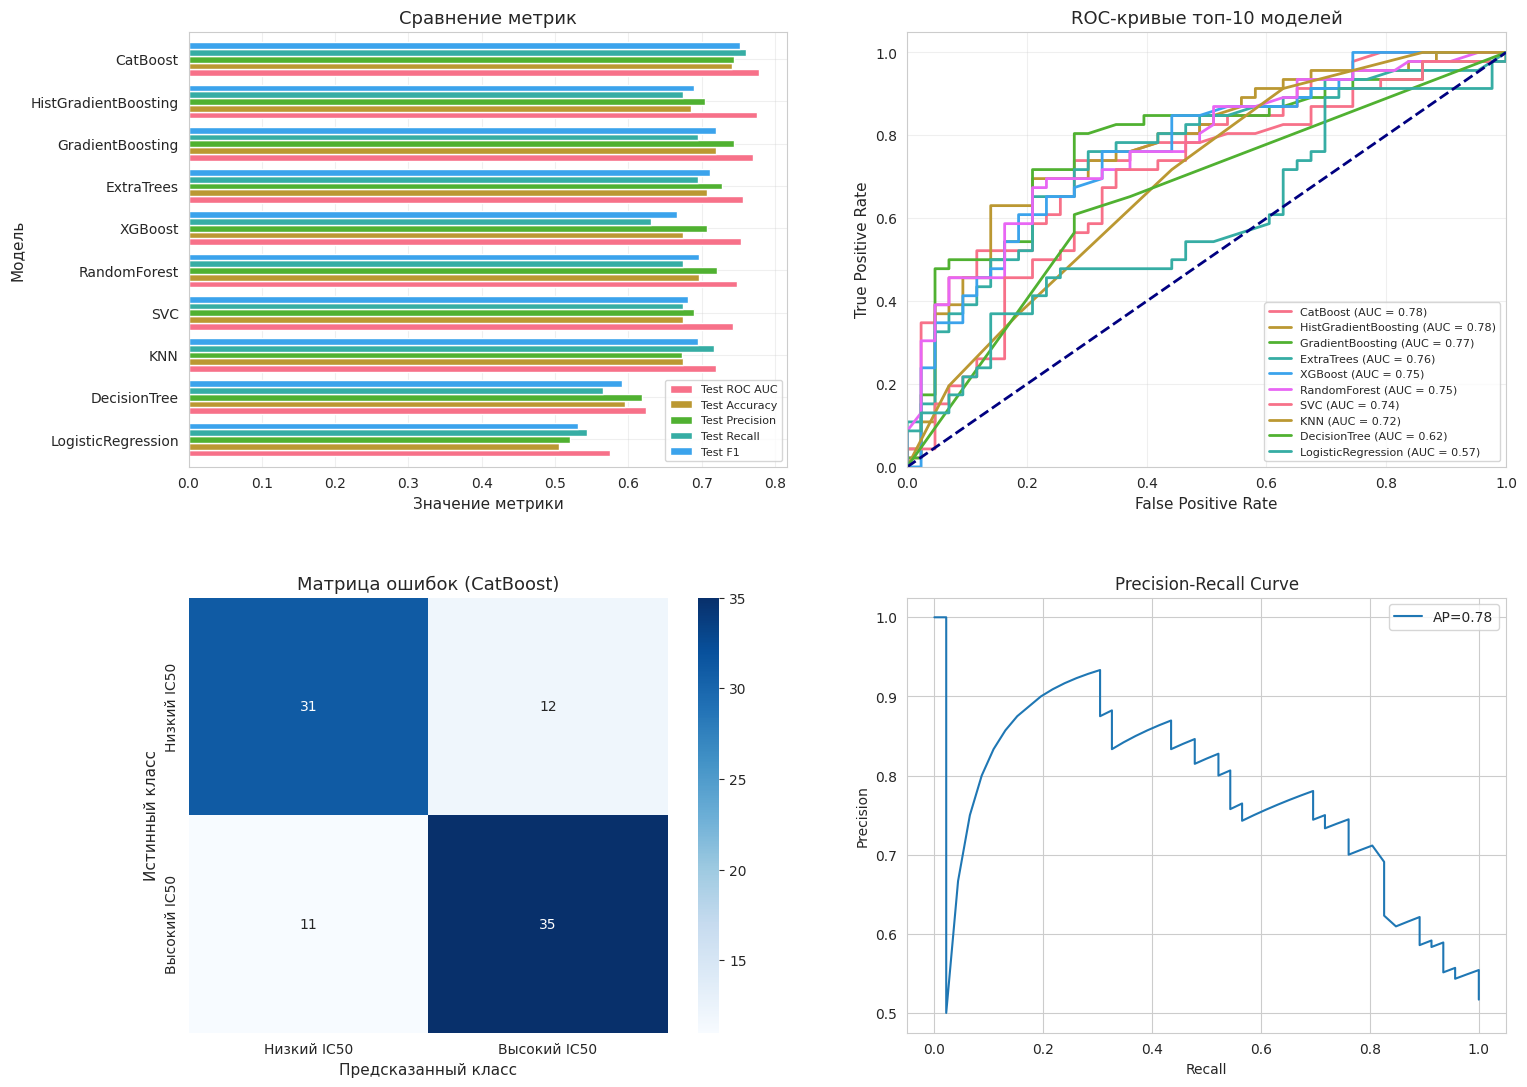

Модель CatBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/SI_class8_handmade_catboost.pkl
Модель HistGradientBoosting сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/SI_class8_handmade_histgradientboosting.pkl
Модель GradientBoosting сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/SI_class8_handmade_gradientboosting.pkl
Модель ExtraTrees сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/SI_class8_handmade_extratrees.pkl
Модель XGBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/SI_class8_handmade_xgboost.pkl
Метрики топ-5 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/SI_class8_handmade_metrics.csv


In [ ]:
# @title Тест моделей на ручных данных
# инициализация
evaluator_handmade = ClassificationModelEvaluator(X1, y1, metod_name=metod_name_1) # ПОМЕНЯТЬ ТУТ!
results = evaluator_handmade.evaluate_models(verbose=True, metrics_filename=table_1)
results_handmade = results.copy()

# Диаграмки
visualizer = ClassificationResultsVisualizer(evaluator_handmade, results_df = results_handmade)
visualizer.visualize_all()

# Сохранение топ-3 моделей
saved_files = evaluator_handmade.save_top_models(n=5, prefix=final_1)

In [ ]:
results_handmade.head(5)

,Metod,Best Parameters,CV ROC AUC,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC AUC,Confusion Matrix,Classification Report
Model,,,,,,,,,,
CatBoost,handmade,"{'depth': 7, 'iterations': 300, 'l2_leaf_reg':...",0.688548,0.741573,0.744681,0.760870,0.752688,0.778059,"[[31, 12], [11, 35]]","{'0': {'precision': 0.7380952380952381, 'recal..."
HistGradientBoosting,handmade,"{'learning_rate': 0.05, 'max_depth': 10, 'max_...",0.689482,0.685393,0.704545,0.673913,0.688889,0.775531,"[[30, 13], [15, 31]]","{'0': {'precision': 0.6666666666666666, 'recal..."
GradientBoosting,handmade,"{'learning_rate': 0.2, 'max_depth': 10, 'min_s...",0.690462,0.719101,0.744186,0.695652,0.719101,0.770475,"[[32, 11], [14, 32]]","{'0': {'precision': 0.6956521739130435, 'recal..."
ExtraTrees,handmade,"{'max_depth': None, 'min_samples_split': 5, 'n...",0.688757,0.707865,0.727273,0.695652,0.711111,0.756320,"[[31, 12], [14, 32]]","{'0': {'precision': 0.6888888888888889, 'recal..."
XGBoost,handmade,"{'colsample_bytree': 1.0, 'learning_rate': 0.2...",0.691555,0.674157,0.707317,0.630435,0.666667,0.753792,"[[31, 12], [17, 29]]","{'0': {'precision': 0.6458333333333334, 'recal..."


Подбор параметров LogisticRegression...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
выполнено: Test ROC AUC: 0.714
Подбор параметров SVC...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
выполнено: Test ROC AUC: 0.676
Подбор параметров KNN...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
выполнено: Test ROC AUC: 0.733
Подбор параметров DecisionTree...
Fitting 3 folds for each of 63 candidates, totalling 189 fits
выполнено: Test ROC AUC: 0.577
Подбор параметров RandomForest...
Fitting 3 folds for each of 126 candidates, totalling 378 fits
выполнено: Test ROC AUC: 0.708
Подбор параметров ExtraTrees...
Fitting 3 folds for each of 63 candidates, totalling 189 fits
выполнено: Test ROC AUC: 0.705
Подбор параметров GradientBoosting...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
выполнено: Test ROC AUC: 0.724
Подбор параметров HistGradientBoosting...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
выполнено: Test 

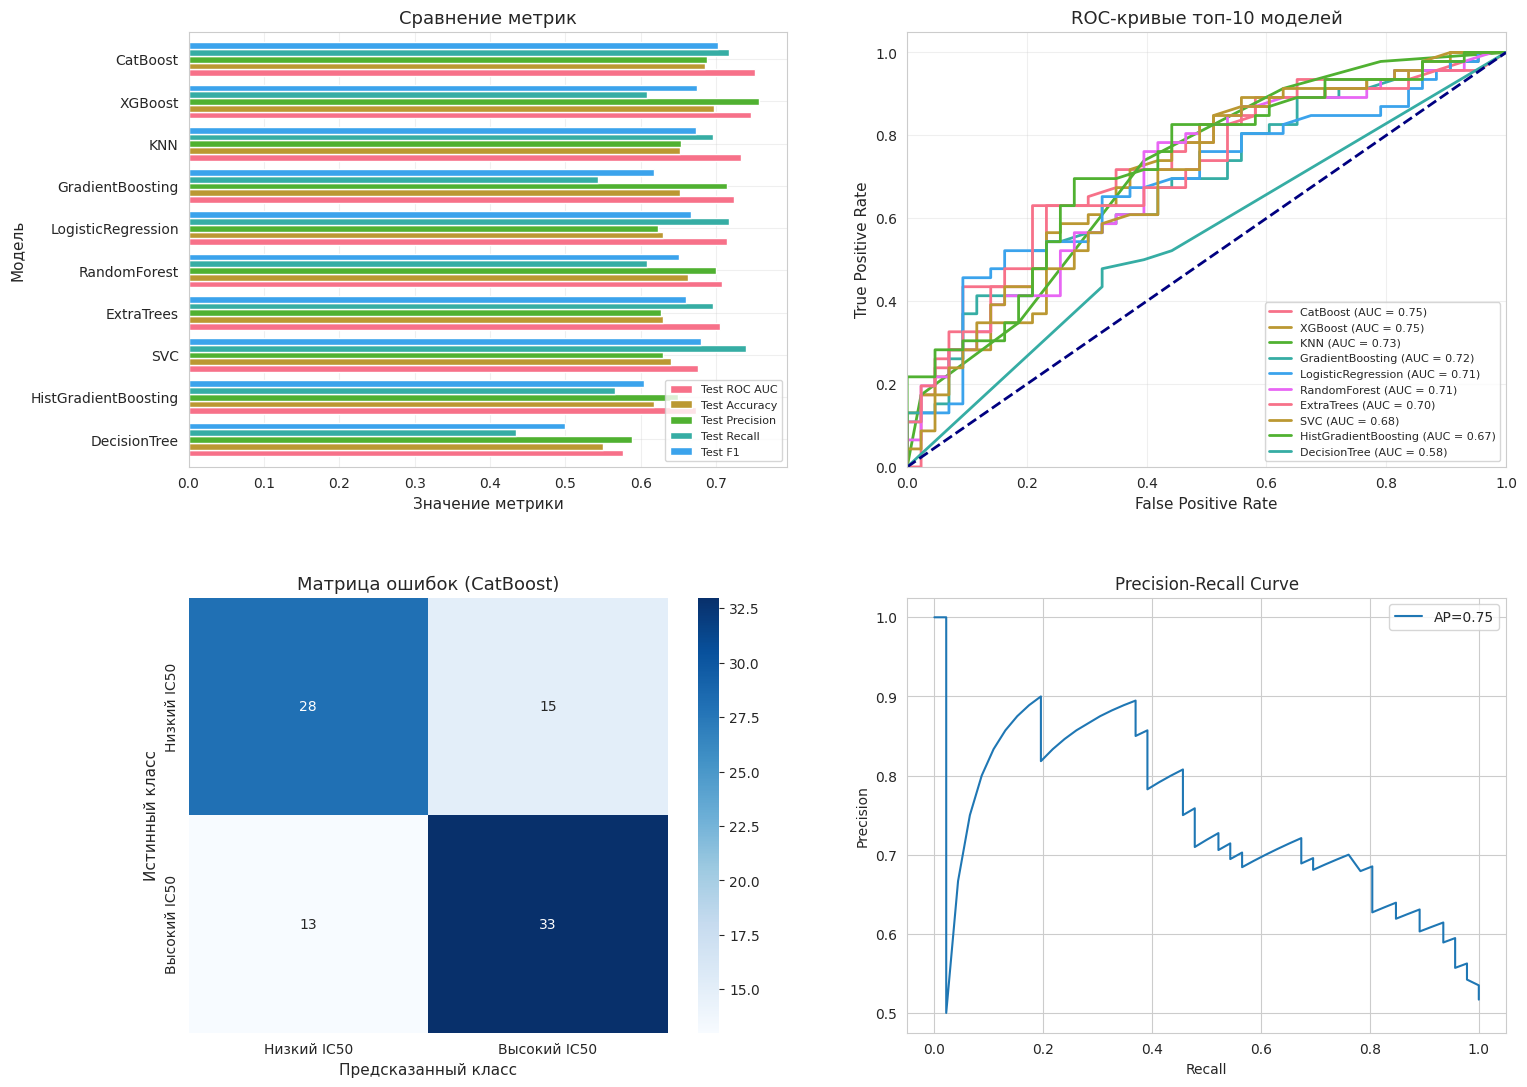

Модель CatBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/SI_class8_pca_catboost.pkl
Модель XGBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/SI_class8_pca_xgboost.pkl
Модель KNN сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/SI_class8_pca_knn.pkl
Модель GradientBoosting сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/SI_class8_pca_gradientboosting.pkl
Модель LogisticRegression сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/SI_class8_pca_logisticregression.pkl
Метрики топ-5 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/SI_class8_pca_metrics.csv


In [ ]:
# @title Тест моделей на даннык, масштабированных PCA
# инициализация
evaluator_pca = ClassificationModelEvaluator(X2, y2, metod_name=metod_name_2) # ПОМЕНЯТЬ ТУТ!
results = evaluator_pca.evaluate_models(verbose=True, metrics_filename=table_2)
results_pca = results.copy()

# Диаграмки
visualizer = ClassificationResultsVisualizer(evaluator_pca, results_df = results_pca)
visualizer.visualize_all()

# Сохранение топ-3 моделей
saved_files = evaluator_pca.save_top_models(n=5, prefix=final_2)

In [ ]:
results_pca.head(5)

,Metod,Best Parameters,CV ROC AUC,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC AUC,Confusion Matrix,Classification Report
Model,,,,,,,,,,
CatBoost,pca,"{'depth': 5, 'iterations': 100, 'l2_leaf_reg':...",0.657456,0.685393,0.687500,0.717391,0.702128,0.752275,"[[28, 15], [13, 33]]","{'0': {'precision': 0.6829268292682927, 'recal..."
XGBoost,pca,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.650429,0.696629,0.756757,0.608696,0.674699,0.746714,"[[34, 9], [18, 28]]","{'0': {'precision': 0.6538461538461539, 'recal..."
KNN,pca,"{'kneighborsclassifier__n_neighbors': 8, 'knei...",0.675465,0.651685,0.653061,0.695652,0.673684,0.732811,"[[26, 17], [14, 32]]","{'0': {'precision': 0.65, 'recall': 0.60465116..."
GradientBoosting,pca,"{'learning_rate': 0.2, 'max_depth': 30, 'min_s...",0.647489,0.651685,0.714286,0.543478,0.617284,0.723964,"[[33, 10], [21, 25]]","{'0': {'precision': 0.6111111111111112, 'recal..."
LogisticRegression,pca,"{'logisticregression__C': 100, 'logisticregres...",0.634183,0.629213,0.622642,0.717391,0.666667,0.714358,"[[23, 20], [13, 33]]","{'0': {'precision': 0.6388888888888888, 'recal..."


Подбор параметров LogisticRegression...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


выполнено: Test ROC AUC: 0.505
Подбор параметров SVC...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
выполнено: Test ROC AUC: 0.701
Подбор параметров KNN...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
выполнено: Test ROC AUC: 0.691
Подбор параметров DecisionTree...
Fitting 3 folds for each of 63 candidates, totalling 189 fits
выполнено: Test ROC AUC: 0.616
Подбор параметров RandomForest...
Fitting 3 folds for each of 126 candidates, totalling 378 fits
выполнено: Test ROC AUC: 0.753
Подбор параметров ExtraTrees...
Fitting 3 folds for each of 63 candidates, totalling 189 fits
выполнено: Test ROC AUC: 0.725
Подбор параметров GradientBoosting...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
выполнено: Test ROC AUC: 0.695
Подбор параметров HistGradientBoosting...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
выполнено: Test ROC AUC: 0.718
Подбор параметров XGBoost...
Fitting 3 folds for each of 216 candidates, totalling 648

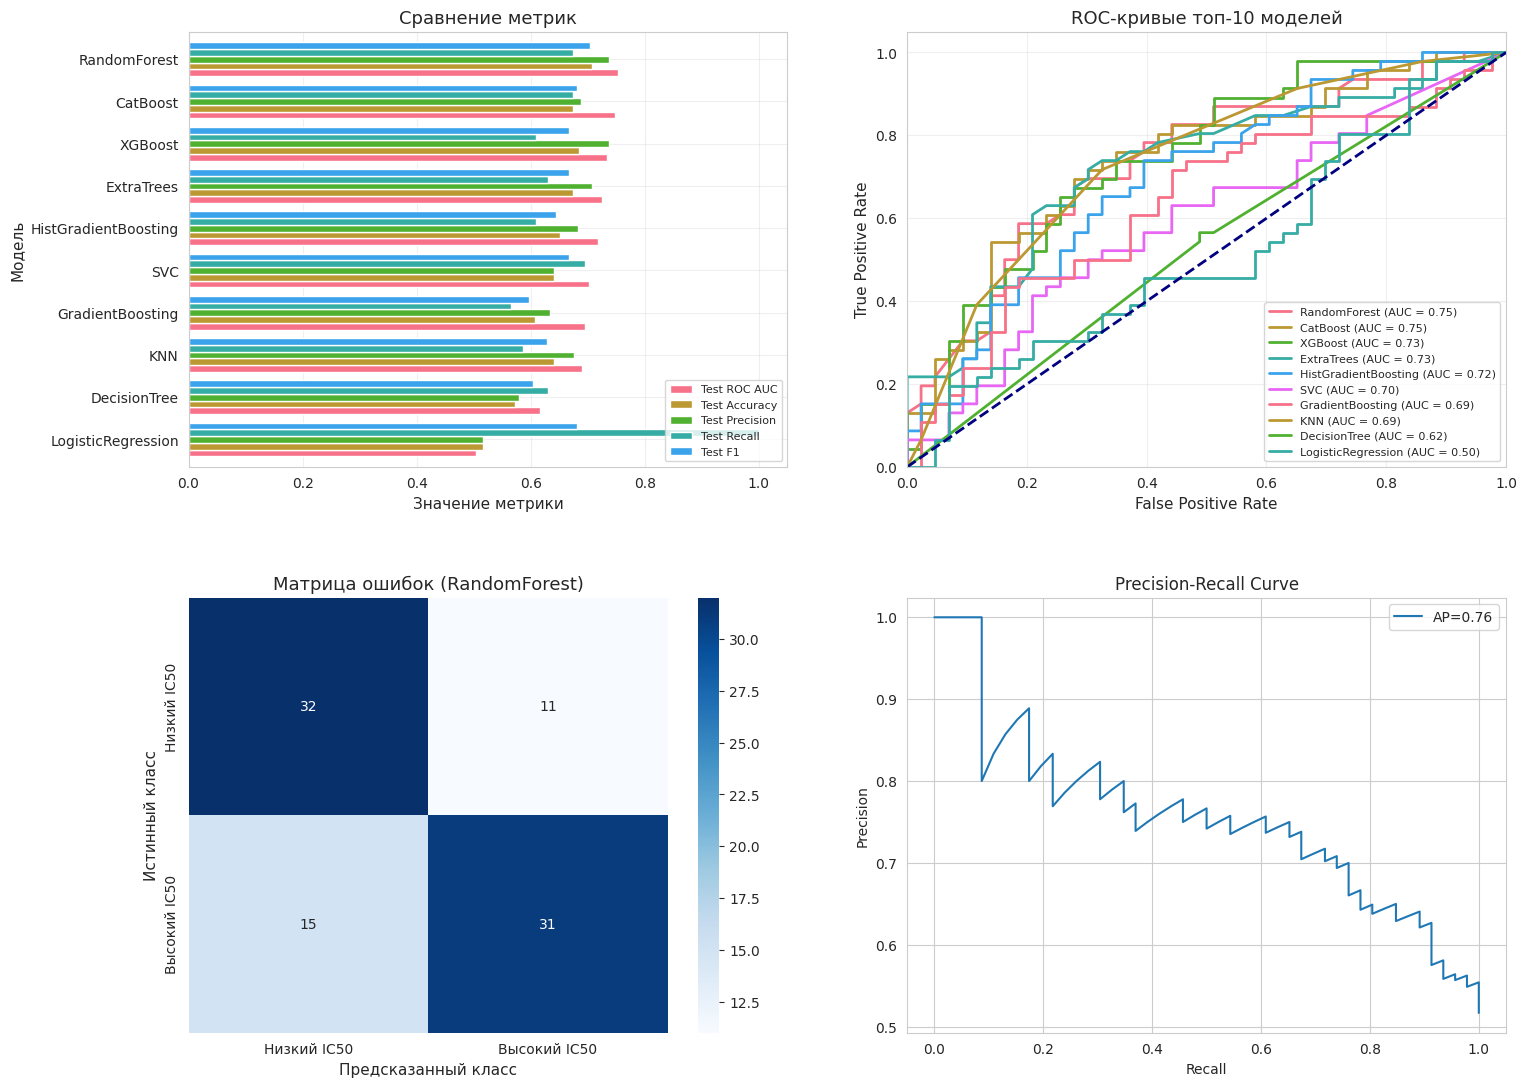

Модель RandomForest сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/SI_class8_tsne_randomforest.pkl
Модель CatBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/SI_class8_tsne_catboost.pkl
Модель XGBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/SI_class8_tsne_xgboost.pkl
Модель ExtraTrees сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/SI_class8_tsne_extratrees.pkl
Модель HistGradientBoosting сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/SI_class8_tsne_histgradientboosting.pkl
Метрики топ-5 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/SI_class8_tsne_metrics.csv


In [ ]:
# @title Тест моделей на даннык, масштабированных tSNE
# инициализация
evaluator_tsne = ClassificationModelEvaluator(X3, y3, metod_name=metod_name_3) # ПОМЕНЯТЬ ТУТ!
results = evaluator_tsne.evaluate_models(verbose=True, metrics_filename=table_3)
results_tsne = results.copy()

# Диаграмки
visualizer = ClassificationResultsVisualizer(evaluator_tsne, results_df = results_tsne)
visualizer.visualize_all()

# Сохранение топ-3 моделей
saved_files = evaluator_tsne.save_top_models(n=5, prefix=final_3)

In [ ]:
results_tsne.head(5)

,Metod,Best Parameters,CV ROC AUC,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC AUC,Confusion Matrix,Classification Report
Model,,,,,,,,,,
RandomForest,tsne,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.612942,0.707865,0.738095,0.673913,0.704545,0.753286,"[[32, 11], [15, 31]]","{'0': {'precision': 0.6808510638297872, 'recal..."
CatBoost,tsne,"{'depth': 10, 'iterations': 300, 'l2_leaf_reg'...",0.619141,0.674157,0.688889,0.673913,0.681319,0.747219,"[[29, 14], [15, 31]]","{'0': {'precision': 0.6590909090909091, 'recal..."
XGBoost,tsne,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.575794,0.685393,0.736842,0.608696,0.666667,0.733569,"[[33, 10], [18, 28]]","{'0': {'precision': 0.6470588235294118, 'recal..."
ExtraTrees,tsne,"{'max_depth': None, 'min_samples_split': 2, 'n...",0.623518,0.674157,0.707317,0.630435,0.666667,0.725228,"[[31, 12], [17, 29]]","{'0': {'precision': 0.6458333333333334, 'recal..."
HistGradientBoosting,tsne,"{'learning_rate': 0.2, 'max_depth': 20, 'max_i...",0.568336,0.651685,0.682927,0.608696,0.643678,0.718402,"[[30, 13], [18, 28]]","{'0': {'precision': 0.625, 'recall': 0.6976744..."


Подбор параметров LogisticRegression...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
выполнено: Test ROC AUC: 0.523
Подбор параметров SVC...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
выполнено: Test ROC AUC: 0.653
Подбор параметров KNN...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
выполнено: Test ROC AUC: 0.764
Подбор параметров DecisionTree...
Fitting 3 folds for each of 63 candidates, totalling 189 fits
выполнено: Test ROC AUC: 0.747
Подбор параметров RandomForest...
Fitting 3 folds for each of 126 candidates, totalling 378 fits
выполнено: Test ROC AUC: 0.772
Подбор параметров ExtraTrees...
Fitting 3 folds for each of 63 candidates, totalling 189 fits
выполнено: Test ROC AUC: 0.797
Подбор параметров GradientBoosting...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
выполнено: Test ROC AUC: 0.746
Подбор параметров HistGradientBoosting...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
выполнено: Test 

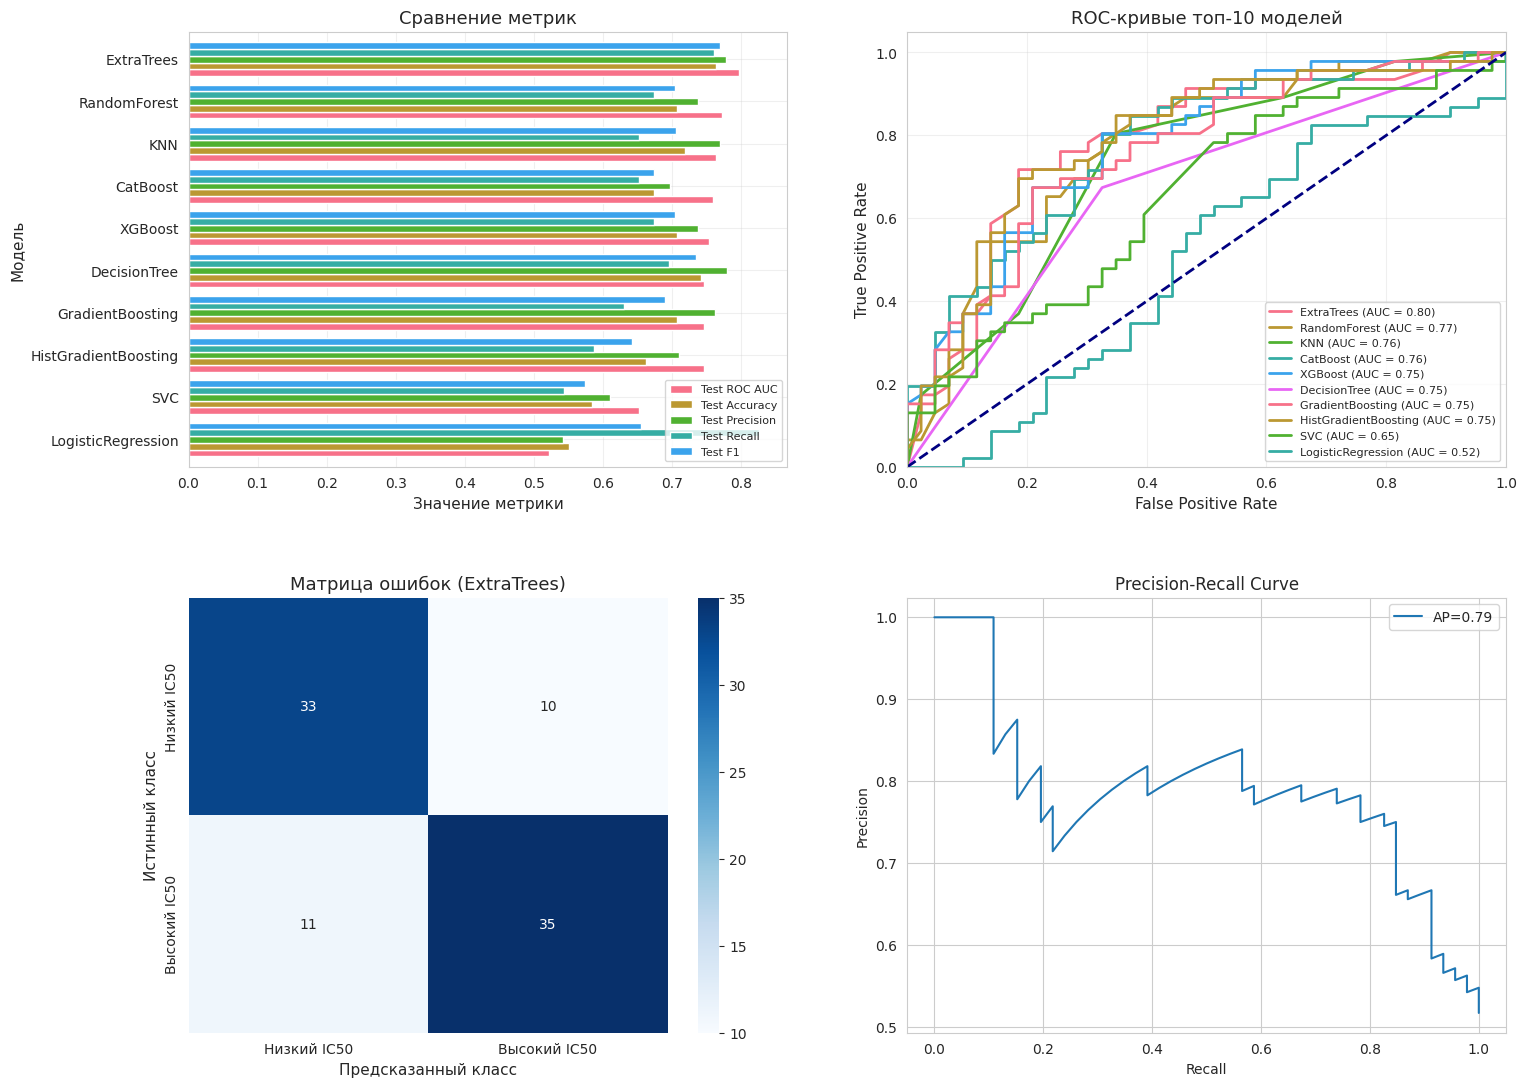

Модель ExtraTrees сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/SI_class8_umap_extratrees.pkl
Модель RandomForest сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/SI_class8_umap_randomforest.pkl
Модель KNN сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/SI_class8_umap_knn.pkl
Модель CatBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/SI_class8_umap_catboost.pkl
Модель XGBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/SI_class8_umap_xgboost.pkl
Метрики топ-5 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/SI_class8_umap_metrics.csv


In [ ]:
# @title Тест моделей на даннык, масштабированных UMAP
# инициализация
evaluator_umap = ClassificationModelEvaluator(X4, y4, metod_name=metod_name_4) # ПОМЕНЯТЬ ТУТ!
results = evaluator_umap.evaluate_models(verbose=True, metrics_filename=table_4)
results_umap = results.copy()

# Диаграмки
visualizer = ClassificationResultsVisualizer(evaluator_umap, results_df = results_umap)
visualizer.visualize_all()

# Сохранение топ-3 моделей
saved_files = evaluator_umap.save_top_models(n=5, prefix=final_4)

In [ ]:
results_umap.head(5)

,Metod,Best Parameters,CV ROC AUC,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC AUC,Confusion Matrix,Classification Report
Model,,,,,,,,,,
ExtraTrees,umap,"{'max_depth': 20, 'min_samples_split': 5, 'n_e...",0.637723,0.764045,0.777778,0.760870,0.769231,0.796764,"[[33, 10], [11, 35]]","{'0': {'precision': 0.75, 'recall': 0.76744186..."
RandomForest,umap,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.621114,0.707865,0.738095,0.673913,0.704545,0.772245,"[[32, 11], [15, 31]]","{'0': {'precision': 0.6808510638297872, 'recal..."
KNN,umap,"{'kneighborsclassifier__n_neighbors': 3, 'knei...",0.628372,0.719101,0.769231,0.652174,0.705882,0.764408,"[[34, 9], [16, 30]]","{'0': {'precision': 0.68, 'recall': 0.79069767..."
CatBoost,umap,"{'depth': 5, 'iterations': 200, 'l2_leaf_reg':...",0.619488,0.674157,0.697674,0.652174,0.674157,0.759100,"[[30, 13], [16, 30]]","{'0': {'precision': 0.6521739130434783, 'recal..."
XGBoost,umap,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",0.603717,0.707865,0.738095,0.673913,0.704545,0.754297,"[[32, 11], [15, 31]]","{'0': {'precision': 0.6808510638297872, 'recal..."


# СВОД И ВЫВОДЫ

In [ ]:
# @title Датасет с результатами всех моделей на валидационной выборке
# Список файлов с результатами
result_files = [table_1, table_2, table_3, table_4]

# Создаем список для хранения датафреймов
dfs = []

# Читаем каждый файл и добавляем в список
for file in result_files:
    # Полный путь к файлу
    file_path = os.path.join(data_dir, file)

    # Читаем CSV
    df = pd.read_csv(file_path)

    # Добавляем столбец с типом данных (из имени файла)
    data_type = file.split('_')[1]  # Извлекаем 'handmade', 'pca', 'tsne', 'umap'
    df['Data_Type'] = data_type

    # Добавляем в список
    dfs.append(df)

# Объединяем все датафреймы
combined_results = pd.concat(dfs, ignore_index=True)

# Сохраняем объединенный результат
combined_results.to_csv(os.path.join(data_dir, csv_file_final), index=False)

# Выводим первые строки для проверки
combined_results_for_view=combined_results.drop(['Best Parameters'], axis = 1)
combined_results_for_view = combined_results_for_view.sort_values(by='Test ROC AUC', ascending=False)
combined_results_for_view.head(5)

,Model,Metod,CV ROC AUC,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC AUC,Confusion Matrix,Classification Report,Data_Type
30,ExtraTrees,umap,0.637723,0.764045,0.777778,0.760870,0.769231,0.796764,[[33 10]\n [11 35]],"{'0': {'precision': 0.75, 'recall': 0.76744186...",SI
0,CatBoost,handmade,0.688548,0.741573,0.744681,0.760870,0.752688,0.778059,[[31 12]\n [11 35]],"{'0': {'precision': 0.7380952380952381, 'recal...",SI
1,HistGradientBoosting,handmade,0.689482,0.685393,0.704545,0.673913,0.688889,0.775531,[[30 13]\n [15 31]],"{'0': {'precision': 0.6666666666666666, 'recal...",SI
31,RandomForest,umap,0.621114,0.707865,0.738095,0.673913,0.704545,0.772245,[[32 11]\n [15 31]],"{'0': {'precision': 0.6808510638297872, 'recal...",SI
2,GradientBoosting,handmade,0.690462,0.719101,0.744186,0.695652,0.719101,0.770475,[[32 11]\n [14 32]],"{'0': {'precision': 0.6956521739130435, 'recal...",SI


In [ ]:
# @title вытащим гиперпарамаетры выбранной модели
filtered_row = combined_results[(combined_results['Model'] == "ExtraTrees") & (combined_results['Metod'] == "umap")]
value = filtered_row.iloc[0]['Best Parameters']
value

"{'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}"

In [ ]:
# @title ШПАРГАЛКА с гиперпараметрами базовых
'''models_config = {
            'LogisticRegression': {
                'model': make_pipeline(
                    StandardScaler(),
                    LogisticRegression(max_iter=2000)
                ),
                'params': {
                    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
                    'logisticregression__penalty': ['l2'],
                    'logisticregression__solver': ['lbfgs', 'liblinear', 'saga']
                }
            },
            'SVC': {
                'model': make_pipeline(
                    StandardScaler(),
                    SVC(probability=True)
                ),
                'params': {
                    'svc__C': [0.1, 1, 10],
                    'svc__kernel': ['linear', 'rbf'],
                    'svc__gamma': ['scale', 'auto']
                }
            },
            'KNN': {
                'model': make_pipeline(
                    StandardScaler(),
                    KNeighborsClassifier()
                ),
                'params': {
                    'kneighborsclassifier__n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
                    'kneighborsclassifier__weights': ['uniform', 'distance'],
                    'kneighborsclassifier__p': [1, 2]
                }
            },
            'DecisionTree': {
                'model': DecisionTreeClassifier(random_state=self.random_state),
                'params': {
                    'max_depth': [None, 3, 5, 7, 10, 20, 30],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4]
                }
            },
            'RandomForest': {
                'model': RandomForestClassifier(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'max_depth': [None, 3, 5, 7, 10, 20, 30],
                    'min_samples_split': [2, 5, 10],
                    'max_features': ['sqrt', 'log2']
                }
            },
            'ExtraTrees': {
                'model': ExtraTreesClassifier(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'max_depth': [None, 3, 5, 7, 10, 20, 30],
                    'min_samples_split': [2, 5, 10]
                }
            },
            'GradientBoosting': {
                'model': GradientBoostingClassifier(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'learning_rate': [0.05, 0.1, 0.2],
                    'max_depth': [3, 5, 7, 10, 20, 30],
                    'min_samples_split': [2, 5, 10]
                }
            },
            'HistGradientBoosting': {
                'model': HistGradientBoostingClassifier(random_state=self.random_state),
                'params': {
                    'max_iter': [100, 200, 300],
                    'learning_rate': [0.05, 0.1, 0.2],
                    'max_depth': [3, 5, 7, 10, 20, 30],
                    'min_samples_leaf': [10, 20]
                }
            },
            'XGBoost': {
                'model': XGBClassifier(random_state=self.random_state, eval_metric='logloss'),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'learning_rate': [0.05, 0.1, 0.2],
                    'max_depth': [3, 5, 7, 10, 20, 30],
                    'subsample': [0.8, 1.0],
                    'colsample_bytree': [0.8, 1.0]
                }
            },
            'CatBoost': {
                'model': CatBoostClassifier(random_state=self.random_state, silent=True),
                'params': {
                    'iterations': [100, 200, 300],
                    'learning_rate': [0.05, 0.1, 0.2],
                    'depth': [3, 5, 7, 10],
                    'l2_leaf_reg': [3, 5]
                }
            }
        }
evaluator = RegressionModelEvaluator(X1, y1, models_config=my_models_config)
results = evaluator.evaluate_models()"""

SyntaxError: incomplete input (<ipython-input-19-ee39e2f3bafb>, line 2)

In [ ]:
# @title ТЮНИНГ ТОП 3 МОДЕЛЕЙ
random_state=42

# конструктор имен файлов для сохранения
base_name_final_top3 = f"{base_parameter}_{analyse_name}_final"
csv_file_final_top3 = f"results_{base_name_final_top3}.csv"
comparison_file_final_top3 = f"comparison_{base_name_final_top3}_"
model_file_final_top3 = f"model_{base_name_final_top3}_"

# модели и гиперпараметры
models_config_final_top3 = {
    'SVC': {
        'model': make_pipeline(
            StandardScaler(),
            SVC(probability=True)
        ),
        'params': {
            'svc__C': [0.1, 1, 10],
            'svc__kernel': ['linear', 'rbf'],
            'svc__gamma': ['scale', 'auto']
        }
    }
}
# инициализация
evaluator_top3 = ClassificationModelEvaluator(X1, y1, models_config=models_config_final_top3, metod_name=metod_name_1) # ПОМЕНЯТЬ ТУТ!

# оценка моделей
results = evaluator_top3.evaluate_models()

# создаем таблицу с промежуточным результатом для итогового сравнения моделей
results_handmade = results.copy()
results_handmade['metod'] = metod_name_1 # ПОМЕНЯТЬ ТУТ!
columns_order = ['metod'] + [col for col in results.columns]
results_top3 = results_handmade[columns_order]

# предсказания (автоматически преобразуются обратно из логарифмической шкалы)
predictions = evaluator_top3.predict(X1) # ПОМЕНЯТЬ ТУТ!
predictions_top3 = predictions

# сохраненние общего результата
results_top3_id = results_top3.reset_index()
results_top3_id.to_csv(os.path.join(data_dir, csv_file_final_top3), index=False) # ПОМЕНЯТЬ ТУТ!

# сохраненние ТОП 3 моделей с метриками и картинками
evaluator_top3.save_comparison_results(n=3, prefix=comparison_file_final_top3, data_dir=data_dir) # ПОМЕНЯТЬ ТУТ!
evaluator_top3.save_top_models(n=3, prefix=model_file_final_top3 , data_dir=data_dir) # ПОМЕНЯТЬ ТУТ!

visualizer = ClassificationResultsVisualizer(evaluator_top3, results_df = results_top3)
visualizer.visualize_all()